In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb

In [2]:
from sklearn import preprocessing
from sklearn.model_selection import KFold, cross_val_score, train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

In [396]:
train=pd.read_csv('train.csv')

In [397]:
test=pd.read_csv('test.csv')

### First look at the data and contents 

In [398]:
train.shape, test.shape

((3865, 80), (890, 79))

In [399]:
train

,galactic year,galaxy,existence expectancy index,existence expectancy at birth,Gross income per capita,Income Index,Expected years of education (galactic years),Mean years of education (galactic years),Intergalactic Development Index (IDI),Education Index,...,"Intergalactic Development Index (IDI), female","Intergalactic Development Index (IDI), male",Gender Development Index (GDI),"Intergalactic Development Index (IDI), female, Rank","Intergalactic Development Index (IDI), male, Rank",Adjusted net savings,"Creature Immunodeficiency Disease prevalence, adult (% ages 15-49), total",Private galaxy capital flows (% of GGP),Gender Inequality Index (GII),y
0,990025,Large Magellanic Cloud (LMC),0.628657,63.125200,27109.234310,0.646039,8.240543,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.052590
1,990025,Camelopardalis B,0.818082,81.004994,30166.793958,0.852246,10.671823,4.742470,0.833624,0.467873,...,NaN,NaN,NaN,NaN,NaN,19.177926,NaN,22.785018,NaN,0.059868
2,990025,Virgo I,0.659443,59.570534,8441.707353,0.499762,8.840316,5.583973,0.469110,0.363837,...,NaN,NaN,NaN,NaN,NaN,21.151265,6.534020,NaN,NaN,0.050449
3,990025,UGC 8651 (DDO 181),0.555862,52.333293,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,5.912194,NaN,NaN,0.049394
4,990025,Tucana Dwarf,0.991196,81.802464,81033.956906,1.131163,13.800672,13.188907,0.910341,0.918353,...,NaN,NaN,NaN,NaN,NaN,NaN,5.611753,NaN,NaN,0.154247
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3860,1015056,Columba I,1.029704,82.832063,34310.471408,0.855094,18.578586,10.557143,0.906573,0.862826,...,0.943410,0.902237,1.060532,124.564121,143.907576,26.438719,3.023709,29.294865,0.580785,0.042324
3861,1015056,"Leo II Dwarf (Leo B, DDO 93)",0.937869,75.877098,36899.067719,0.929494,16.153857,9.151665,0.865822,0.747577,...,0.915225,0.798083,1.055118,163.664516,184.291155,20.637654,4.470596,31.085400,0.517558,0.036725
3862,1015056,Canes Venatici I Dwarf,1.036144,93.540275,37002.977875,1.085245,21.066473,16.661344,0.983835,1.100779,...,1.097208,1.044890,1.114754,66.498714,112.887035,28.154859,5.193997,32.145570,0.363862,0.166271
3863,1015056,KKs 3,0.939034,78.274427,28180.459770,0.687655,9.388911,8.908748,0.735694,0.602703,...,0.596164,0.754729,0.825864,182.249079,175.408953,38.963157,2.854140,27.227179,0.711878,0.024187


In [400]:
train.columns

Index(['galactic year', 'galaxy', 'existence expectancy index',
       'existence expectancy at birth', 'Gross income per capita',
       'Income Index', 'Expected years of education (galactic years)',
       'Mean years of education (galactic years)',
       'Intergalactic Development Index (IDI)', 'Education Index',
       'Intergalactic Development Index (IDI), Rank',
       'Population using at least basic drinking-water services (%)',
       'Population using at least basic sanitation services (%)',
       'Gross capital formation (% of GGP)', 'Population, total (millions)',
       'Population, urban (%)',
       'Mortality rate, under-five (per 1,000 live births)',
       'Mortality rate, infant (per 1,000 live births)',
       'Old age dependency ratio (old age (65 and older) per 100 creatures (ages 15-64))',
       'Population, ages 15–64 (millions)',
       'Population, ages 65 and older (millions)',
       'Life expectancy at birth, male (galactic years)',
       'Life expect

In [401]:
# There is a lot of NaN's. Check the count

train.count()

galactic year                                                                3865
galaxy                                                                       3865
existence expectancy index                                                   3864
existence expectancy at birth                                                3864
Gross income per capita                                                      3837
                                                                             ... 
Adjusted net savings                                                          912
Creature Immunodeficiency Disease prevalence, adult (% ages 15-49), total     941
Private galaxy capital flows (% of GGP)                                       874
Gender Inequality Index (GII)                                                 844
y                                                                            3865
Length: 80, dtype: int64

In [402]:
# Write the columns with NaN countings

def columns_with_nans(data):
    list_buff = []
    k = 0
    total_rows = data.shape[0]
    for column in data.count().keys():
        if data.count()[column] < total_rows:
            list_buff.append([column, data.shape[0] - data.count()[column], round((data.shape[0] - data.count()[column])/data.shape[0],4)])
            k += 1
            
    if k == 0:
        print ('There is no NaNs in the data')
    else:
        return(list_buff)
            
col_wth_nan = columns_with_nans(train)
col_wth_nan_df = pd.DataFrame(col_wth_nan, columns = ['name', 'NaN num', 'NaN percentage'])

### Comment

There is a lot of NaN in last columns (> 70%). But  3865 - 3021 ~ 800 of unique data. We cannot drop them. The best way is to fill them by mean value.

In [403]:
# Since we have regression task, fill NaN by the means (0 is also eglible, but will affect the model)

train_nan = train # train with NaN's
# train = train_nan.fillna(0)
train = train_nan.fillna(train.mean())

In [404]:
train

,galactic year,galaxy,existence expectancy index,existence expectancy at birth,Gross income per capita,Income Index,Expected years of education (galactic years),Mean years of education (galactic years),Intergalactic Development Index (IDI),Education Index,...,"Intergalactic Development Index (IDI), female","Intergalactic Development Index (IDI), male",Gender Development Index (GDI),"Intergalactic Development Index (IDI), female, Rank","Intergalactic Development Index (IDI), male, Rank",Adjusted net savings,"Creature Immunodeficiency Disease prevalence, adult (% ages 15-49), total",Private galaxy capital flows (% of GGP),Gender Inequality Index (GII),y
0,990025,Large Magellanic Cloud (LMC),0.628657,63.125200,27109.234310,0.646039,8.240543,10.283959,0.804246,0.745900,...,0.823561,0.844209,1.008465,121.754797,120.873428,21.252922,6.443023,22.261474,0.600733,0.052590
1,990025,Camelopardalis B,0.818082,81.004994,30166.793958,0.852246,10.671823,4.742470,0.833624,0.467873,...,0.823561,0.844209,1.008465,121.754797,120.873428,19.177926,6.443023,22.785018,0.600733,0.059868
2,990025,Virgo I,0.659443,59.570534,8441.707353,0.499762,8.840316,5.583973,0.469110,0.363837,...,0.823561,0.844209,1.008465,121.754797,120.873428,21.151265,6.534020,22.261474,0.600733,0.050449
3,990025,UGC 8651 (DDO 181),0.555862,52.333293,31633.240872,0.825154,14.723296,10.283959,0.804246,0.745900,...,0.823561,0.844209,1.008465,121.754797,120.873428,21.252922,5.912194,22.261474,0.600733,0.049394
4,990025,Tucana Dwarf,0.991196,81.802464,81033.956906,1.131163,13.800672,13.188907,0.910341,0.918353,...,0.823561,0.844209,1.008465,121.754797,120.873428,21.252922,5.611753,22.261474,0.600733,0.154247
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3860,1015056,Columba I,1.029704,82.832063,34310.471408,0.855094,18.578586,10.557143,0.906573,0.862826,...,0.943410,0.902237,1.060532,124.564121,143.907576,26.438719,3.023709,29.294865,0.580785,0.042324
3861,1015056,"Leo II Dwarf (Leo B, DDO 93)",0.937869,75.877098,36899.067719,0.929494,16.153857,9.151665,0.865822,0.747577,...,0.915225,0.798083,1.055118,163.664516,184.291155,20.637654,4.470596,31.085400,0.517558,0.036725
3862,1015056,Canes Venatici I Dwarf,1.036144,93.540275,37002.977875,1.085245,21.066473,16.661344,0.983835,1.100779,...,1.097208,1.044890,1.114754,66.498714,112.887035,28.154859,5.193997,32.145570,0.363862,0.166271
3863,1015056,KKs 3,0.939034,78.274427,28180.459770,0.687655,9.388911,8.908748,0.735694,0.602703,...,0.596164,0.754729,0.825864,182.249079,175.408953,38.963157,2.854140,27.227179,0.711878,0.024187


In [405]:
# Check

_ = columns_with_nans(train)

There is no NaNs in the data


NaN's is filled. But we have a string type in the 'galaxy' column. Let's check other columns

In [406]:
for record in train.iloc[1,:]:
    if type(record) == str:
        print(record)

Camelopardalis B


### Only one column with string type. Let's process it

In [357]:
train = train.drop(columns=['galaxy'])

## Do the same for test set

In [358]:
col_wth_nan_test = columns_with_nans(test)
col_wth_nan_df_test = pd.DataFrame(col_wth_nan_test, columns = ['name', 'NaN num', 'NaN percentage'])
col_wth_nan_df_test

,name,NaN num,NaN percentage
0,existence expectancy index,5,0.0056
1,existence expectancy at birth,5,0.0056
2,Gross income per capita,5,0.0056
3,Income Index,5,0.0056
4,Expected years of education (galactic years),5,0.0056
...,...,...,...
72,"Intergalactic Development Index (IDI), male, Rank",341,0.3831
73,Adjusted net savings,371,0.4169
74,"Creature Immunodeficiency Disease prevalence, ...",408,0.4584
75,Private galaxy capital flows (% of GGP),354,0.3978


In [359]:
test_nan = test # test with NaN's
# test = test.fillna(0)
test = test.fillna(test.mean())

In [360]:
test = test.drop(columns=['galaxy'])
test

,galactic year,existence expectancy index,existence expectancy at birth,Gross income per capita,Income Index,Expected years of education (galactic years),Mean years of education (galactic years),Intergalactic Development Index (IDI),Education Index,"Intergalactic Development Index (IDI), Rank",...,Current health expenditure (% of GGP),"Intergalactic Development Index (IDI), female","Intergalactic Development Index (IDI), male",Gender Development Index (GDI),"Intergalactic Development Index (IDI), female, Rank","Intergalactic Development Index (IDI), male, Rank",Adjusted net savings,"Creature Immunodeficiency Disease prevalence, adult (% ages 15-49), total",Private galaxy capital flows (% of GGP),Gender Inequality Index (GII)
0,1007012,0.456086,51.562543,12236.576447,0.593325,10.414164,10.699072,0.547114,0.556267,232.621842,...,8.936240,0.848007,0.862777,1.015743,128.712080,128.635268,20.640391,6.036133,23.274262,0.563059
1,1007012,0.529835,57.228262,3431.883825,0.675407,7.239485,5.311122,0.497688,0.409969,247.580771,...,8.936240,0.848007,0.862777,1.015743,128.712080,128.635268,20.640391,6.036133,23.274262,0.563059
2,1008016,0.560976,59.379539,27562.914252,0.594624,11.774890,5.937797,0.544744,0.486167,249.798771,...,8.936240,0.848007,0.862777,1.015743,128.712080,128.635268,20.640391,6.036133,23.274262,0.563059
3,1007012,0.565910,59.952390,20352.232905,0.837700,11.613621,10.067882,0.691641,0.523441,211.505060,...,8.936240,0.848007,0.862777,1.015743,128.712080,128.635268,20.640391,6.036133,23.274262,0.563059
4,1013042,0.588274,55.428320,23959.704016,0.520579,10.392416,6.374637,0.530676,0.580418,234.721069,...,7.357729,0.583373,0.600445,0.856158,206.674424,224.104054,20.640391,7.687626,23.274262,0.563059
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
885,1016064,0.923881,79.938370,33655.513114,0.856869,16.037675,11.229365,0.845626,0.801581,147.296372,...,8.936240,0.848007,0.862777,1.015743,128.712080,128.635268,20.640391,6.036133,23.274262,0.563059
886,1016064,0.923881,79.938370,33655.513114,0.856869,16.037675,11.229365,0.845626,0.801581,147.296372,...,8.936240,0.848007,0.862777,1.015743,128.712080,128.635268,20.640391,6.036133,23.274262,0.563059
887,1016064,0.923881,79.938370,33655.513114,0.856869,16.037675,11.229365,0.845626,0.801581,147.296372,...,8.936240,0.848007,0.862777,1.015743,128.712080,128.635268,20.640391,6.036133,23.274262,0.563059
888,1016064,0.923881,79.938370,33655.513114,0.856869,16.037675,11.229365,0.845626,0.801581,147.296372,...,8.936240,0.848007,0.862777,1.015743,128.712080,128.635268,20.640391,6.036133,23.274262,0.563059


Let's do simple fit-predict. But initially we should do normalization.

Below you can see why we should implement it

In [361]:
train.max()
total_rows = train.shape[0]
for column in train.max().keys():
    if column != 'galaxy':
        if train.max()[column] > 1000:
            print(column, train.max()[column])

galactic year 1015056.0
Gross income per capita 151072.68315568598
Population, total (millions) 7993.3235021812025
Population, ages 15–64 (millions) 5542.8092491545995
Gross galactic product (GGP) per capita 134636.6480532842
Gross galactic product (GGP), total 112391.3167350178
Maternal mortality ratio (deaths per 100,000 live births) 3178.3336959457515
Estimated gross galactic income per capita, male 187663.56977139536
Estimated gross galactic income per capita, female 83638.7765428038
Intergalactic inbound tourists (thousands) 1228843.0681437787
Respiratory disease incidence (per 100,000 people) 1380.9148496150672


In [362]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet

import time
import datetime

In [363]:
common_features=list(set(train.columns).intersection(set(test.columns)))

In [364]:
y_train=train['y']
X_train=train[common_features]
X_test=test[common_features]

In [365]:
# Data normalization using StandartScaler

scaler = StandardScaler()
# scaler = normalize()
scaler.fit(X_train)
X_std_train = scaler.transform(X_train)
X_std_test = scaler.transform(X_test)

X_std_train

array([[ 0.00000000e+00, -1.69387792e+00, -6.94971252e-16, ...,
         2.10159866e-15, -6.08261393e-16,  0.00000000e+00],
       [ 0.00000000e+00, -5.58287523e-01, -6.94971252e-16, ...,
        -1.63910248e+00, -6.08261393e-16, -8.78108190e-01],
       [ 0.00000000e+00, -3.44356928e+00, -6.94971252e-16, ...,
        -2.44872287e+00, -6.08261393e-16, -4.74082498e+00],
       ...,
       [-2.41282968e+00,  1.47074663e+00,  1.65151441e+00, ...,
         2.97478196e+00,  6.40779405e-01,  2.11044351e+00],
       [ 1.02734797e+00, -1.66093623e-01, -1.33274073e+00, ...,
        -9.58229390e-01, -4.93101643e-01, -2.39398717e+00],
       [-1.20225255e+00,  2.21089304e+00,  1.88533039e+00, ...,
         1.84528077e+00,  1.70573514e+00,  1.57442101e+00]])

In [366]:
X_std_test

array([[-0.07646553,  0.45612054,  0.05351607, ...,  0.4242925 ,
        -1.52785524,  0.39804866],
       [-0.07646553,  0.45612054,  0.05351607, ...,  0.4242925 ,
        -2.29932709,  0.39804866],
       [-0.07646553,  0.45612054,  0.05351607, ...,  0.4242925 ,
        -2.18461385,  0.39804866],
       ...,
       [-0.07646553,  0.45612054,  0.05351607, ...,  0.4242925 ,
         0.06865049,  0.39804866],
       [-0.07646553,  0.45612054,  0.05351607, ...,  0.4242925 ,
         0.06865049,  0.39804866],
       [-0.07646553,  0.45612054,  0.05351607, ...,  0.4242925 ,
         0.06865049,  0.39804866]])

Data prepared. Let's try first implementations

In [367]:
reg = LinearRegression().fit(X_std_train, y_train)

In [368]:
reg.score(X_std_train, y_train)

0.638636818205206

In [369]:
np.mean((reg.predict(X_std_train) - y_train)**2)

0.0014528453342669543

In [370]:
# reg.coef_

In [371]:
result_reg = reg.predict(X_std_test)
len(result_reg)

890

In [145]:
result_reg

array([ 6.11571312e-03, -1.40369169e-02,  5.69137222e-03,  2.07048558e-02,
        2.68529535e-02, -2.48196853e-02,  7.70374798e-03,  1.94418822e-02,
        3.71807085e-02,  1.45499873e-02,  1.09867153e-02,  3.72123421e-03,
        2.32093412e-02,  9.56366786e-03,  2.11414739e-02,  4.73599214e-02,
        1.37858639e-02,  3.66410768e-02,  8.26966002e-03,  1.53564097e-02,
        2.80260772e-02,  3.80094530e-03,  9.24697598e-03, -3.59092646e-02,
        5.92335695e-02,  2.39944413e-02,  5.79561356e-03,  4.47744747e-02,
        2.30538442e-02,  3.24780936e-02,  1.88856807e-02, -4.44857747e-03,
        9.24203362e-03,  1.26328907e-02,  8.38132001e-03,  1.32813889e-02,
        3.21482876e-02,  1.44968684e-02,  7.57186565e-04,  2.51296514e-02,
        1.54282315e-02, -8.34865333e-03,  2.11644309e-02,  2.72669247e-02,
        1.63212163e-02,  2.95944525e-02,  1.78943998e-02,  3.58598723e-02,
       -9.73681014e-03,  2.07017732e-02,  2.16570272e-02,  1.65053876e-02,
        2.08067519e-02,  

In [146]:
# DO CROSSVALIDATION - done
# IMPLEMENT REGULARISATION - done
# IMPLEMENT OPT_PRED (OPT PROBLEM) - done
# TRY TO IMPLEMENT NEURAL NETWORK

In [147]:
# Function for time and metrics dependency by regularization

def scores_time_regularization(alpha, l1_ratio, X, y, max_iter=10000, tol=0.0013, verbose=None):

    start_time = datetime.datetime.now()

    reg = ElasticNet(alpha, l1_ratio, max_iter=max_iter, tol=tol)

    kf = KFold(n_splits=5, shuffle=True)
    kf.get_n_splits(X)

    # for train_index, test_index in kf.split(X):
    #     print("TRAIN:", train_index, "TEST:", test_index)
    #     X_train, X_test = X[train_index], X[test_index]
    #     y_train, y_test = y[train_index], y[test_index]

    scores = 0
    for train, test in kf.split(X):
#         X_train, X_test, y_train, y_test = X.loc[train], X.loc[test], y.loc[train], y.loc[test]
        X_train, X_test, y_train, y_test = X[train], X[test], y[train], y[test]
        reg.fit(X_train, y_train) 
        pred = reg.predict(X_test)
        scores += np.mean((pred - y_test)**2)
    scores = scores/5
    
    if verbose:
        print('alpha = ', alpha, ', l1_ratio = ',l1_ratio, ', with RMSE = ', scores)
    
    time_res = datetime.datetime.now() - start_time
    
    if verbose:
        print ('Time elapsed:', time_res)
    
    return(scores, time_res)

In [148]:
alpha = 5
l1_ratio = 1

scores_time_regularization(alpha, l1_ratio, X_std_train, y_train, verbose = True)

alpha =  5 , l1_ratio =  1 , with RMSE =  0.004021255681869125
Time elapsed: 0:00:00.175948


(0.004021255681869125, datetime.timedelta(0, 0, 175948))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.031312018660688, tolerance: 0.01587742124545372
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9962061602880212, tolerance: 0.015751528255113365
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0754349308841022, tolerance: 0.016555665556190764
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Dua

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.0995213759977145, tolerance: 0.015662208351434836
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.3005397727919616, tolerance: 0.01663619204575039
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.243191772925729, tolerance: 0.016552776049530808
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Dua

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.7855456979517377, tolerance: 0.01676441904010822
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.574695747913044, tolerance: 0.015961306270296835
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.432839498213219, tolerance: 0.015623773102074629
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Dual

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.044019249615897, tolerance: 0.016743661605284697
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.8552213645497018, tolerance: 0.0158915749679018
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.8653427585270443, tolerance: 0.015786600343415412
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Dual

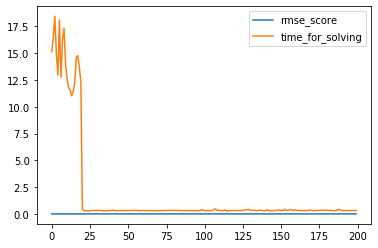

In [58]:
# Quality dependence by alpha and l1_ratio

alpha = np.linspace(0.1,5,20)
l1_ratio = np.linspace(0,1,10) # l1_ratio = 1 corresponds to Lasso

rmse_score = np.empty(len(alpha)*len(l1_ratio))
op_time = np.empty(len(alpha)*len(l1_ratio))

for i in range(0,len(l1_ratio)):
    for j in range(0,len(alpha)):
        score, time = scores_time_regularization(alpha[j], l1_ratio[i], X_std_train, y_train, max_iter=1000)
        rmse_score[i*len(alpha) + j] = score
        op_time[i*len(alpha) + j] = time.total_seconds()

x = range(len(alpha)*len(l1_ratio))        
        
plt.plot(x,rmse_score)
plt.plot(x,op_time)
plt.legend(['rmse_score','time_for_solving'])

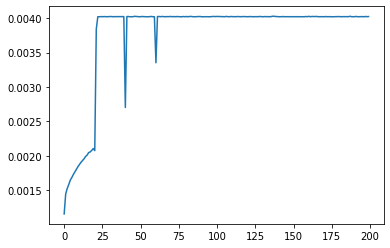

In [59]:
plt.plot(x,rmse_score)

Let's look at l1_ratio = [0,0.1] more accurate. But we should take into account a possibility to overtrain

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.107849058746055, tolerance: 0.016452512457702635
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1640112534710667, tolerance: 0.016993189545554413
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.03571202721838, tolerance: 0.01621538459127384
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duali

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.2720466241312076, tolerance: 0.01643833717346376
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.2146233101206576, tolerance: 0.016334659922209435
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.2690092546319702, tolerance: 0.01639997980454197
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Dua

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.6343021577588015, tolerance: 0.016087879023019034
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.6866554668233427, tolerance: 0.016721295610792875
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.5701303811137275, tolerance: 0.01577929674801186
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Du

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.777376325859744, tolerance: 0.015778991922757116
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.8357715975079896, tolerance: 0.01573476712257453
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.8077613559841876, tolerance: 0.015340901775920427
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Dua

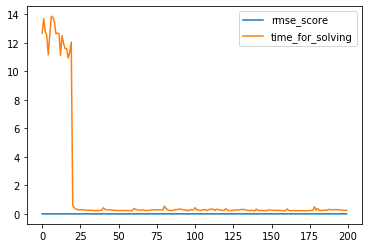

In [60]:
# Quality dependence by alpha and l1_ratio

alpha = np.linspace(0.1,5,20)
l1_ratio = np.linspace(0,0.1,10) # l1_ratio = 1 corresponds to Lasso

rmse_score = np.empty(len(alpha)*len(l1_ratio))
op_time = np.empty(len(alpha)*len(l1_ratio))

for i in range(0,len(l1_ratio)):
    for j in range(0,len(alpha)):
        score, time = scores_time_regularization(alpha[j], l1_ratio[i], X_std_train, y_train, max_iter=10000)
        rmse_score[i*len(alpha) + j] = score
        op_time[i*len(alpha) + j] = time.total_seconds()

x = range(len(alpha)*len(l1_ratio))        
        
plt.plot(x,rmse_score)
plt.plot(x,op_time)
plt.legend(['rmse_score','time_for_solving'])

In [150]:
plt.plot(x,rmse_score)

NameError: name 'rmse_score' is not defined

In [151]:
alpha=0.1
l1_ratio=0

score,_ = scores_time_regularization(alpha, l1_ratio, X_std_train, y_train, max_iter=10000)
print(score)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.549310559771568, tolerance: 0.015658071879228772
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.6515168191768237, tolerance: 0.016228475092215183
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.5162285123239627, tolerance: 0.015511943798679444
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Du

0.0016292628464500691


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.835706494757893, tolerance: 0.017059012478068
  positive)


We can try to use alpha=0.1, l1_ratio=0 to predict 'y' in test data

In [ ]:
alpha = 0.1
l1_ratio = 0
max_iter = 10000

regr = ElasticNet(alpha, l1_ratio, max_iter=max_iter)
regr.fit(X_std_train, y_train)
result = regr.predict(X_bag_std_test)

print('regr_score on train: ', regr.score(X_bag_std_train, y_train))
print('RMSE on train: ', np.mean((regr.predict(X_bag_std_train) - y_train)**2))
print('result: ', result)

LinearRegression showed the better result. Let's use it.

In [37]:
test_res = result_reg

## Trying TF modeling

In [98]:
import tensorflow as tf

In [164]:
print(tf.__version__)

2.0.0


In [165]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib
import seaborn as sns

from tensorflow import keras
from tensorflow.keras import layers

Load datasets again

In [221]:
train_nan

,galactic year,galaxy,existence expectancy index,existence expectancy at birth,Gross income per capita,Income Index,Expected years of education (galactic years),Mean years of education (galactic years),Intergalactic Development Index (IDI),Education Index,...,"Intergalactic Development Index (IDI), female","Intergalactic Development Index (IDI), male",Gender Development Index (GDI),"Intergalactic Development Index (IDI), female, Rank","Intergalactic Development Index (IDI), male, Rank",Adjusted net savings,"Creature Immunodeficiency Disease prevalence, adult (% ages 15-49), total",Private galaxy capital flows (% of GGP),Gender Inequality Index (GII),y
0,990025,Large Magellanic Cloud (LMC),0.628657,63.125200,27109.234310,0.646039,8.240543,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.052590
1,990025,Camelopardalis B,0.818082,81.004994,30166.793958,0.852246,10.671823,4.742470,0.833624,0.467873,...,NaN,NaN,NaN,NaN,NaN,19.177926,NaN,22.785018,NaN,0.059868
2,990025,Virgo I,0.659443,59.570534,8441.707353,0.499762,8.840316,5.583973,0.469110,0.363837,...,NaN,NaN,NaN,NaN,NaN,21.151265,6.534020,NaN,NaN,0.050449
3,990025,UGC 8651 (DDO 181),0.555862,52.333293,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,5.912194,NaN,NaN,0.049394
4,990025,Tucana Dwarf,0.991196,81.802464,81033.956906,1.131163,13.800672,13.188907,0.910341,0.918353,...,NaN,NaN,NaN,NaN,NaN,NaN,5.611753,NaN,NaN,0.154247
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3860,1015056,Columba I,1.029704,82.832063,34310.471408,0.855094,18.578586,10.557143,0.906573,0.862826,...,0.943410,0.902237,1.060532,124.564121,143.907576,26.438719,3.023709,29.294865,0.580785,0.042324
3861,1015056,"Leo II Dwarf (Leo B, DDO 93)",0.937869,75.877098,36899.067719,0.929494,16.153857,9.151665,0.865822,0.747577,...,0.915225,0.798083,1.055118,163.664516,184.291155,20.637654,4.470596,31.085400,0.517558,0.036725
3862,1015056,Canes Venatici I Dwarf,1.036144,93.540275,37002.977875,1.085245,21.066473,16.661344,0.983835,1.100779,...,1.097208,1.044890,1.114754,66.498714,112.887035,28.154859,5.193997,32.145570,0.363862,0.166271
3863,1015056,KKs 3,0.939034,78.274427,28180.459770,0.687655,9.388911,8.908748,0.735694,0.602703,...,0.596164,0.754729,0.825864,182.249079,175.408953,38.963157,2.854140,27.227179,0.711878,0.024187


In [239]:
train = train_nan
test = test_nan

Fill NaN's

In [240]:
train = train.fillna(train.mean())
# train = train.fillna(0)
test = test.fillna(test.mean())
# test = test.fillna(0)

Drop Galaxy names

In [241]:
train = train.drop(columns='galaxy')
test = test.drop(columns='galaxy')

Split train set for cross-validation

In [242]:
train_dataset = train.sample(frac=0.8,random_state=0)
test_dataset = train.drop(train_dataset.index)

First look at features again

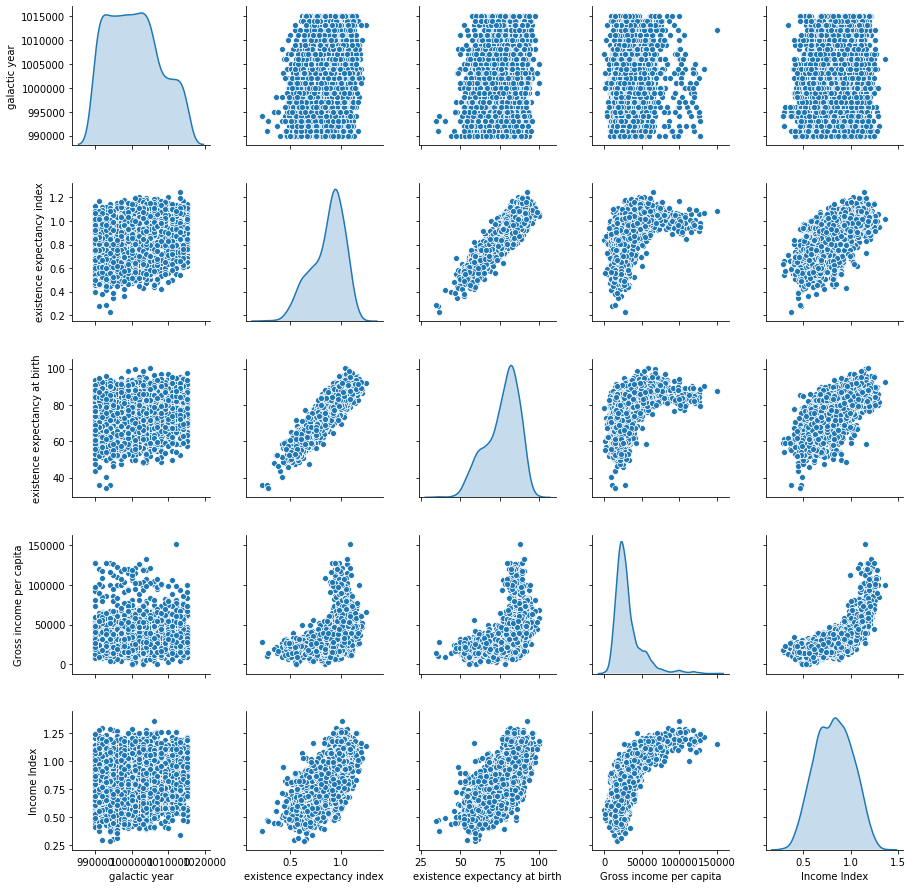

In [184]:
sns.pairplot(train_dataset[['galactic year', 'existence expectancy index',
       'existence expectancy at birth', 'Gross income per capita',
       'Income Index']], diag_kind='kde')

In [186]:
train_stats = train_dataset.describe()
train_stats.pop('y')
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
galactic year,3092.0,1.000737e+06,6991.333173,990025.000000,995006.000000,1000000.000000,1.006009e+06,1.015056e+06
existence expectancy index,3092.0,8.721909e-01,0.162203,0.227890,0.761481,0.905862,9.912101e-01,1.246908e+00
existence expectancy at birth,3092.0,7.679630e+01,10.427550,34.244062,69.990343,78.916358,8.454652e+01,1.002101e+02
Gross income per capita,3092.0,3.148416e+04,18364.391847,-126.906522,20285.983471,26690.929355,3.681211e+04,1.510727e+05
Income Index,3092.0,8.249657e-01,0.191796,0.292001,0.678224,0.825154,9.687668e-01,1.361883e+00
...,...,...,...,...,...,...,...,...
"Intergalactic Development Index (IDI), male, Rank",3092.0,1.209385e+02,22.731223,16.215151,120.873428,120.873428,1.208734e+02,2.339154e+02
Adjusted net savings,3092.0,2.121371e+01,6.908212,-76.741414,21.252922,21.252922,2.125292e+01,6.190364e+01
"Creature Immunodeficiency Disease prevalence, adult (% ages 15-49), total",3092.0,6.466010e+00,2.440249,0.118915,6.443023,6.443023,6.443023e+00,3.182211e+01
Private galaxy capital flows (% of GGP),3092.0,2.242298e+01,11.506128,-403.107076,22.261474,22.261474,2.226147e+01,9.594124e+01


Split target label

In [187]:
train_labels = train_dataset.pop('y')
test_labels = test_dataset.pop('y')

In [189]:
test_labels

0       0.052590
3       0.049394
7       0.062652
21      0.052660
24      0.050460
          ...   
3834    0.056742
3835    0.473119
3838    0.058778
3855    0.034301
3858    0.164000
Name: y, Length: 773, dtype: float64

Normalization

In [190]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

Model building

In [191]:
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    return model

In [192]:
model = build_model()

Model checking

In [193]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                5056      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 9,281
Trainable params: 9,281
Non-trainable params: 0
_________________________________________________________________


Checking outputs

In [194]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.22232443],
       [-0.06376285],
       [-0.13043049],
       [-0.10189641],
       [ 0.14510053],
       [-0.16950026],
       [ 0.2014707 ],
       [-0.02070057],
       [-0.20160013],
       [ 0.6682451 ]], dtype=float32)

Neural Network learning process

In [195]:
# Print the learning progress by points after the every epoch end
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

EPOCHS = 1000

history = model.fit(
    normed_train_data, train_labels,
    epochs=EPOCHS, validation_split = 0.2, verbose=0,
    callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

Let's look at the history data

In [196]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,0.000032,0.003190,0.000032,0.000990,0.018161,0.000990,995
996,0.000021,0.002829,0.000021,0.001013,0.017901,0.001013,996
997,0.000031,0.003219,0.000031,0.000963,0.017937,0.000963,997
998,0.000027,0.003079,0.000027,0.000929,0.018131,0.000929,998
999,0.000030,0.003115,0.000030,0.001013,0.018195,0.001013,999


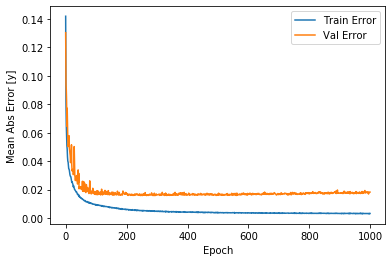

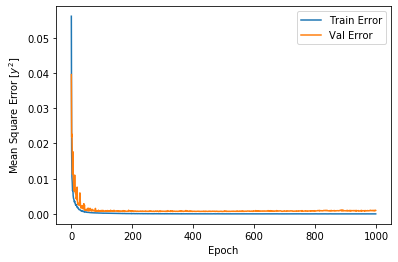

In [198]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [y]')
    plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
#     plt.ylim([0,5])
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$y^2$]')
    plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
#     plt.ylim([0,20])
    plt.legend()
    plt.show()


plot_history(history)

We can see here validation error increasing, what can lead us to model overfitting. Try to use 'EarlyStopping Callback'


.......................................................................................

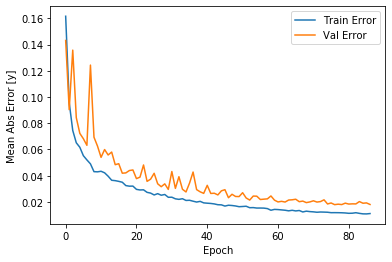

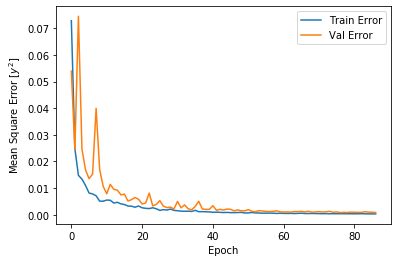

In [199]:
model = build_model()

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

In [202]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Squared Error: {:5.4f} y".format(mse))

773/773 - 0s - loss: 0.0010 - mae: 0.0191 - mse: 0.0010
Testing set Mean Squared Error: 0.0010 y


Result is not bad, let's try it on test set

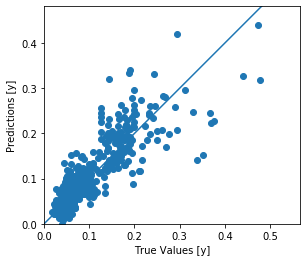

In [203]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [y]')
plt.ylabel('Predictions [y]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

Let's look at the error distribution

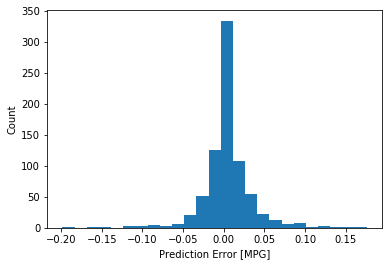

In [204]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

Look's like normal distribution. Central limit theorem is working

### Now let's do predictions for submission

In [250]:
train = train_nan
test = test_nan

# Fill NaN's

train = train.fillna(train.mean())
# train = train.fillna(0)
test = test.fillna(test.mean())
# test = test.fillna(0)

# Drop Galaxy names

train = train.drop(columns='galaxy')
test = test.drop(columns='galaxy')

In [267]:
train_labels = train.pop('y')
test_labels = test.pop('galactic year')

In [268]:
test_labels

0      1007012
1      1007012
2      1008016
3      1007012
4      1013042
        ...   
885    1016064
886    1016064
887    1016064
888    1016064
889    1016064
Name: galactic year, Length: 890, dtype: int64

In [254]:
train_dataset = train
test_dataset = test

In [255]:
train_dataset

,galactic year,existence expectancy index,existence expectancy at birth,Gross income per capita,Income Index,Expected years of education (galactic years),Mean years of education (galactic years),Intergalactic Development Index (IDI),Education Index,"Intergalactic Development Index (IDI), Rank",...,Current health expenditure (% of GGP),"Intergalactic Development Index (IDI), female","Intergalactic Development Index (IDI), male",Gender Development Index (GDI),"Intergalactic Development Index (IDI), female, Rank","Intergalactic Development Index (IDI), male, Rank",Adjusted net savings,"Creature Immunodeficiency Disease prevalence, adult (% ages 15-49), total",Private galaxy capital flows (% of GGP),Gender Inequality Index (GII)
0,990025,0.628657,63.125200,27109.234310,0.646039,8.240543,10.283959,0.804246,0.745900,135.129178,...,8.837096,0.823561,0.844209,1.008465,121.754797,120.873428,21.252922,6.443023,22.261474,0.600733
1,990025,0.818082,81.004994,30166.793958,0.852246,10.671823,4.742470,0.833624,0.467873,152.522198,...,8.837096,0.823561,0.844209,1.008465,121.754797,120.873428,19.177926,6.443023,22.785018,0.600733
2,990025,0.659443,59.570534,8441.707353,0.499762,8.840316,5.583973,0.469110,0.363837,209.813266,...,8.837096,0.823561,0.844209,1.008465,121.754797,120.873428,21.151265,6.534020,22.261474,0.600733
3,990025,0.555862,52.333293,31633.240872,0.825154,14.723296,10.283959,0.804246,0.745900,135.129178,...,8.837096,0.823561,0.844209,1.008465,121.754797,120.873428,21.252922,5.912194,22.261474,0.600733
4,990025,0.991196,81.802464,81033.956906,1.131163,13.800672,13.188907,0.910341,0.918353,71.885345,...,8.837096,0.823561,0.844209,1.008465,121.754797,120.873428,21.252922,5.611753,22.261474,0.600733
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3860,1015056,1.029704,82.832063,34310.471408,0.855094,18.578586,10.557143,0.906573,0.862826,144.896214,...,10.392312,0.943410,0.902237,1.060532,124.564121,143.907576,26.438719,3.023709,29.294865,0.580785
3861,1015056,0.937869,75.877098,36899.067719,0.929494,16.153857,9.151665,0.865822,0.747577,164.692000,...,10.296360,0.915225,0.798083,1.055118,163.664516,184.291155,20.637654,4.470596,31.085400,0.517558
3862,1015056,1.036144,93.540275,37002.977875,1.085245,21.066473,16.661344,0.983835,1.100779,63.726437,...,9.601421,1.097208,1.044890,1.114754,66.498714,112.887035,28.154859,5.193997,32.145570,0.363862
3863,1015056,0.939034,78.274427,28180.459770,0.687655,9.388911,8.908748,0.735694,0.602703,216.805701,...,4.137744,0.596164,0.754729,0.825864,182.249079,175.408953,38.963157,2.854140,27.227179,0.711878


In [256]:
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [257]:
model = build_model()

In [258]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 64)                5056      
_________________________________________________________________
dense_25 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 65        
Total params: 9,281
Trainable params: 9,281
Non-trainable params: 0
_________________________________________________________________


In [259]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.33727854],
       [ 0.2498783 ],
       [-1.3058151 ],
       [ 0.37385833],
       [-0.4886976 ],
       [-0.25380477],
       [-1.2411106 ],
       [-1.834219  ],
       [-0.58539313],
       [-1.4981613 ]], dtype=float32)

Step above is necessary (helped me to understand that I forgot to drop target column from train)

Using 'EarlyStopping Callback' again


................................................................

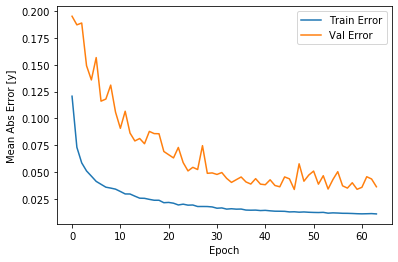

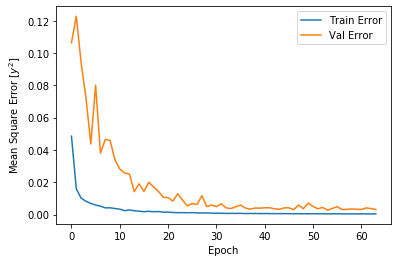

In [379]:
model = build_model()

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

In [380]:
loss, mae, mse = model.evaluate(normed_train_data, train_labels, verbose=2)

print("Testing set Mean Squared Error: {:5.4f} y".format(mse))

3865/3865 - 0s - loss: 8.7948e-04 - mae: 0.0154 - mse: 8.7948e-04
Testing set Mean Squared Error: 0.0009 y


In [381]:
test_predictions_NN = model.predict(normed_test_data).flatten()

In [382]:
test_predictions_NN

array([ 2.77211070e-02,  4.51746136e-02,  4.04219627e-02,  5.54674715e-02,
        5.14699668e-02,  4.87067625e-02,  3.50147374e-02,  4.58114073e-02,
        6.46914393e-02,  8.41769576e-02,  4.65493426e-02,  3.00137550e-02,
        2.28637084e-02,  4.01236117e-02,  4.00708839e-02,  1.85653493e-02,
        3.47045958e-02, -1.89598650e-03,  3.66750658e-02,  4.21851873e-02,
        4.43119109e-02,  4.43136692e-02,  4.18656170e-02,  4.50918898e-02,
        3.70911956e-02,  6.11472651e-02,  3.80919799e-02, -2.40731239e-03,
        4.05957066e-02,  3.02139446e-02,  5.01520783e-02,  4.10292372e-02,
        4.39543203e-02,  3.38392854e-02,  3.79053652e-02,  4.88259718e-02,
        4.97958139e-02,  2.93809995e-02,  4.71449755e-02,  5.02518713e-02,
        4.22149599e-02,  9.09115449e-02,  2.07936019e-03,  4.37009111e-02,
        3.61886770e-02,  1.05900466e-02,  5.20105064e-02,  3.98571156e-02,
        5.37031740e-02,  5.33855408e-02,  4.09254581e-02,  3.68057042e-02,
        3.99786904e-02,  

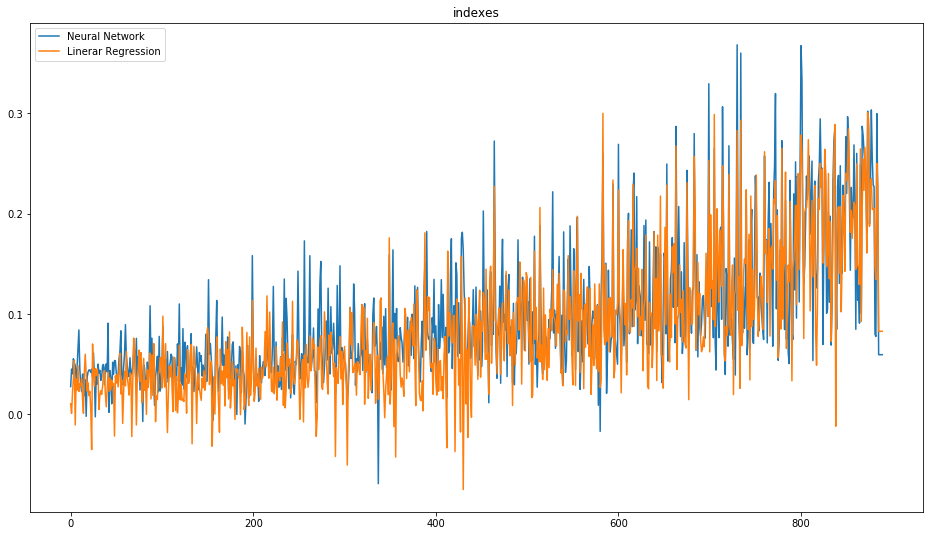

In [383]:
x = range(890)
plt.figure(figsize=(16,9))
plt.title('indexes')
plt.plot(x, test_predictions_NN, label = 'Neural Network')
plt.plot(x, result_reg, label = 'Linerar Regression')
plt.legend()

<bound method Series.min of 0       0.052590
1       0.059868
2       0.050449
3       0.049394
4       0.154247
          ...   
3860    0.042324
3861    0.036725
3862    0.166271
3863    0.024187
3864    0.100069
Name: y, Length: 3865, dtype: float64>


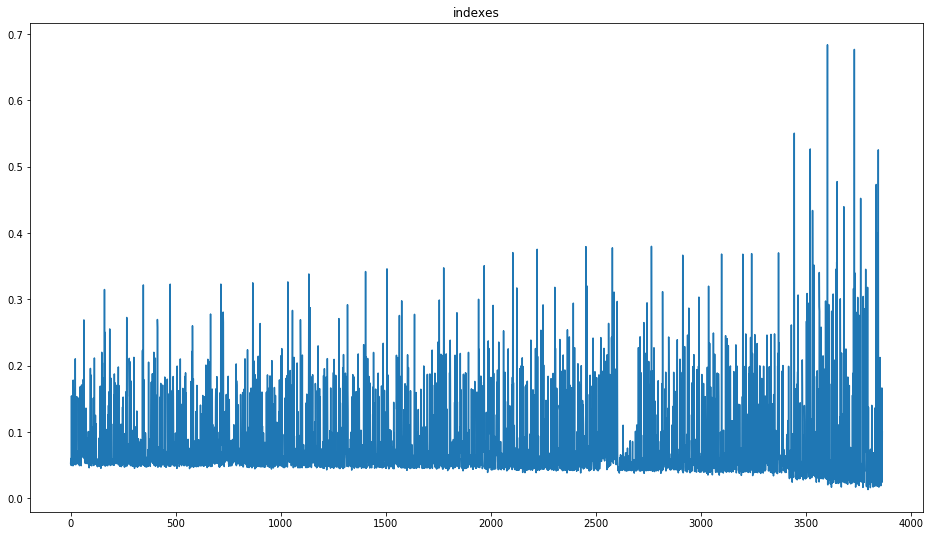

In [318]:
x = range(train_nan.shape[0])
plt.figure(figsize=(16,9))
plt.title('indexes')
plt.plot(x, train_nan['y'])
# plt.legend()

print(train_nan['y'][:].min)

In [378]:
# # kostyl

# test_predictions_NN_modif = np.zeros(train_nan.shape[0])
# result_reg_modif = np.zeros(train_nan.shape[0])

# for i in range(train_nan.shape[0]):
#     if test_predictions_NN[i] < 0.02:
#         test_predictions_NN_modif[i] = 0.02
#     else:
#         test_predictions_NN_modif[i] = test_predictions_NN[i]
        
#     if result_reg[i] < 0.02:
#         result_reg_modif[i] = 0.02
#     else:
#         result_reg_modif[i] = result_reg_modif[i][i]

IndexError: index 890 is out of bounds for axis 0 with size 890

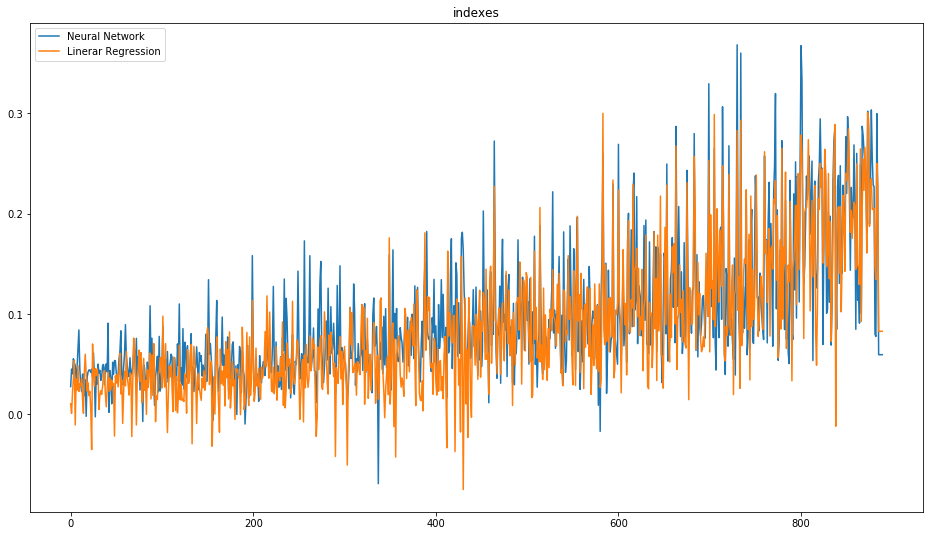

In [384]:
x = range(890)
plt.figure(figsize=(16,9))
plt.title('indexes')
plt.plot(x, test_predictions_NN, label = 'Neural Network')
plt.plot(x, result_reg, label = 'Linerar Regression')
plt.legend()

Choose the best - ...

In [385]:
test_res = test_predictions_NN

## Optimization problem formulation

The only essence that we consume is energy, measured in DSML units…Our populace is widespread and we live across many different star clusters and galaxies. What we need now is to optimize our well-being across all those galaxies… We have a lot of data but our сomputers and methods are too weak – we urgently need your data science knowledge to help us”

“Only two steps prevent us from achieving singularity

· To understand what makes us better off.

Our elders used the composite index to measure our well-being performance, but this knowledge has disappeared in the sands of time.

Use our data and train your model to predict this index with the highest possible level of certainty.

· To achieve the highest possible level of well-being through optimized allocation of additional energy

We have discovered the star of an unusually high energy of 50000 zillion DSML.

We have agreed between ourselves that 

· no one galaxy will consume more than 100 zillion DSML 

and 

· at least 10% of the total energy will be consumed by galaxies in need with existence expectancy index below 0,7.

The solutions are evaluated on two criteria: predicted future Index values and allocated energy from a newly discovered star

1) Index predictions are evaluated using RMSE metric

2) Energy allocation is also evaluated using RMSE metric and has a set of known factors that need to be taken into account.

Every galaxy has a certain limited potential for improvement in the index described by the following function:

Potential for increase in the Index = -np.log(Index+0.01)+3

Likely index increase dependent on potential for improvement and on extra energy availability is described by the following function:

Likely increase in the Index = extra energy * Potential for increase in the Index **2 / 1000

There are also several constraints:

in total there are 50000 zillion DSML available for allocation and no galaxy at a point in time should be allocated more than 100 zillion DSML or less than 0 zillion DSML. Galaxies with low existence expectancy index below 0.7 should be allocated at least 10% of the total energy available in the foreseeable future


In [386]:
test = test_nan
train = train_nan
test = test.fillna(train.mean())
test

,galactic year,galaxy,existence expectancy index,existence expectancy at birth,Gross income per capita,Income Index,Expected years of education (galactic years),Mean years of education (galactic years),Intergalactic Development Index (IDI),Education Index,...,Current health expenditure (% of GGP),"Intergalactic Development Index (IDI), female","Intergalactic Development Index (IDI), male",Gender Development Index (GDI),"Intergalactic Development Index (IDI), female, Rank","Intergalactic Development Index (IDI), male, Rank",Adjusted net savings,"Creature Immunodeficiency Disease prevalence, adult (% ages 15-49), total",Private galaxy capital flows (% of GGP),Gender Inequality Index (GII)
0,1007012,KK98 77,0.456086,51.562543,12236.576447,0.593325,10.414164,10.699072,0.547114,0.556267,...,8.837096,0.823561,0.844209,1.008465,121.754797,120.873428,21.252922,6.443023,22.261474,0.600733
1,1007012,Reticulum III,0.529835,57.228262,3431.883825,0.675407,7.239485,5.311122,0.497688,0.409969,...,8.837096,0.823561,0.844209,1.008465,121.754797,120.873428,21.252922,6.443023,22.261474,0.600733
2,1008016,Reticulum III,0.560976,59.379539,27562.914252,0.594624,11.774890,5.937797,0.544744,0.486167,...,8.837096,0.823561,0.844209,1.008465,121.754797,120.873428,21.252922,6.443023,22.261474,0.600733
3,1007012,Segue 1,0.565910,59.952390,20352.232905,0.837700,11.613621,10.067882,0.691641,0.523441,...,8.837096,0.823561,0.844209,1.008465,121.754797,120.873428,21.252922,6.443023,22.261474,0.600733
4,1013042,Virgo I,0.588274,55.428320,23959.704016,0.520579,10.392416,6.374637,0.530676,0.580418,...,7.357729,0.583373,0.600445,0.856158,206.674424,224.104054,21.252922,7.687626,22.261474,0.600733
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
885,1016064,ESO 383-087 (ISG 39),0.872479,76.798111,31633.240872,0.825154,14.723296,10.283959,0.804246,0.745900,...,8.837096,0.823561,0.844209,1.008465,121.754797,120.873428,21.252922,6.443023,22.261474,0.600733
886,1016064,NGC 247,0.872479,76.798111,31633.240872,0.825154,14.723296,10.283959,0.804246,0.745900,...,8.837096,0.823561,0.844209,1.008465,121.754797,120.873428,21.252922,6.443023,22.261474,0.600733
887,1016064,ESO 325-11,0.872479,76.798111,31633.240872,0.825154,14.723296,10.283959,0.804246,0.745900,...,8.837096,0.823561,0.844209,1.008465,121.754797,120.873428,21.252922,6.443023,22.261474,0.600733
888,1016064,ESO 540-032,0.872479,76.798111,31633.240872,0.825154,14.723296,10.283959,0.804246,0.745900,...,8.837096,0.823561,0.844209,1.008465,121.754797,120.873428,21.252922,6.443023,22.261474,0.600733


In [387]:
import math

In [388]:
# pot_index = []
# for ind in test_res:
#     pot_index.append(-math.log(ind+0.01)+3)

In [389]:
test_res[16]

0.034704596

In [392]:
pot_index = - np.log(test_res + 0.01) + 3

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


In [395]:
pot_index

array([ 6.2775354,  5.897252 ,  5.9873285,  5.726202 ,  5.7892065,
        5.8352003,  6.100765 ,  5.885777 ,  5.59439  ,  5.36258  ,
        5.8726416,  6.218532 ,  6.415386 ,  5.9932632,  5.9943156,
        6.555561 ,  6.1076794,  7.815396 ,  6.064545 ,  5.9529567,
        5.9130116,  5.912979 ,  5.9590993,  5.8987527,  6.0556693,
        5.6430035,  6.03464  ,  7.8805695,  5.9838886,  6.2135415,
        5.810879 ,  5.9753566,  5.9196177,  6.127225 ,  6.0385275,
        5.833172 ,  5.8168197,  6.234472 ,  5.8621635,  5.8092217,
        5.9523864,  5.293511 ,  7.416257 ,  5.9243255,  6.075021 ,
        6.8829474,  5.780452 ,  5.9985943,  5.753521 ,  5.7585196,
        5.977392 ,  6.0617504,  5.9961586,  5.7290416,  5.610734 ,
        5.371479 ,  5.996952 ,  6.2351837,  5.859018 ,  5.6642694,
        5.3077445,  5.6838264,  5.840142 ,  5.9731607,  6.0467005,
        5.71066  ,  6.0037766,  5.972893 ,  5.8647504,  5.583892 ,
        5.603076 ,  6.0443316,  5.4551935,  6.1702027,  5.6919

In [307]:
type(pot_index)

numpy.ndarray

In [44]:
# likely_increase = []
# for ind in pot_index:
#     likely_increase.append(extra * ind**2 / 1000)

In [45]:
import cvxpy as cp

In [46]:
N = test.shape[0]
N

890

In [47]:
galaxies

array(['Large Magellanic Cloud (LMC)', 'Camelopardalis B', 'Virgo I',
       'UGC 8651 (DDO 181)', 'Tucana Dwarf', 'KKh 060', 'Grus II',
       'UGCA 292', 'Aquarius II', 'Andromeda XI', 'Antlia Dwarf',
       'IC 1613 (UGC 668)', 'Leo P',
       'Cassiopeia Dwarf (Cas dSph, Andromeda VII)', 'Draco II',
       'Sagittarius II', 'Carina III', 'UGCA 133 (DDO 44)',
       'Lacerta I (Andromeda XXXI)', 'Boötes IV', 'Maffei 2',
       'KUG 1210+301B (KK98 127)', 'Andromeda V',
       'Sagittarius Dwarf Sphr SagDEG', 'UGCA 276 (DDO 113)',
       'Ursa Minor Dwarf', 'UGC 9128 (DDO 187)', 'Andromeda XX',
       'Segue 2', 'Fornax Dwarf (E356-G04)', 'Columba I', 'KK98 77',
       'Holmberg II (DDO 50, UGC 4305)', 'ESO 540-030 (KDG 2)', 'NGC 404',
       'UGC 8833', 'Perseus I (Andromeda XXXIII)', 'Horologium II',
       'Andromeda XXVI', 'Grus I', 'Andromeda IX', 'Andromeda XXII[57]',
       'ESO 274-01[70]', 'Leo II Dwarf (Leo B, DDO 93)', 'Reticulum II',
       'Andromeda II', 'Indus II', 'MB

In [48]:
# d_galaxies = dict()

In [49]:
# galaxies[0]

In [50]:
# for name in galaxies:
#     d_galaxies.update({name: float(0)})

In [51]:
# d_galaxies

In [52]:
# pot_index[1]
# d_galaxies['IC 5152'] += 1

In [53]:
# i = 1
# print(test['galaxy'][i])
# d_galaxies[test['galaxy'][i]] += 1

In [54]:
# d_galaxies[test['galaxy'][i]] 
# d_galaxies

In [55]:
# create an array for galaxyes list related to rows

row_gal = []
for i in range(N):
    row_gal.append((np.where(galaxies == test['galaxy'][i]))[0][0])

In [56]:
gal_row = []
for i in range(len(galaxies)):
    gal_row.append((np.where(galaxies[i] == test['galaxy']))[0][:])

In [57]:
gal_row

[array([144, 160, 238, 256, 309, 322, 375, 422], dtype=int64),
 array([453, 485, 691, 723], dtype=int64),
 array([ 4, 21, 67], dtype=int64),
 array([14, 56], dtype=int64),
 array([], dtype=int64),
 array([ 24,  55,  74,  77, 108], dtype=int64),
 array([172, 396], dtype=int64),
 array([270, 356], dtype=int64),
 array([178, 180, 244], dtype=int64),
 array([101, 103, 111, 130, 142, 175, 217, 224], dtype=int64),
 array([271, 280, 368, 407, 437], dtype=int64),
 array([107, 156], dtype=int64),
 array([699, 714, 725, 759, 839], dtype=int64),
 array([619, 740, 751, 760, 806, 825, 829, 830], dtype=int64),
 array([143, 298], dtype=int64),
 array([367, 380, 413, 560, 608, 641, 645], dtype=int64),
 array([387, 392, 398, 431, 465, 592, 650, 704], dtype=int64),
 array([ 68,  80, 125, 148, 150, 247, 251, 299], dtype=int64),
 array([151, 218, 243, 262, 274, 308, 390, 416], dtype=int64),
 array([649], dtype=int64),
 array([245, 446], dtype=int64),
 array([234, 330, 357, 363, 456], dtype=int64),
 array(

In [58]:
144 in gal_row[0]

True

In [59]:
lines_gal_row = []
for line in gal_row:
    line_gal_row = np.zeros(N)
    for i in range(N):
        if i in line:
            line_gal_row[i] = 1
    lines_gal_row.append(line_gal_row)

In [60]:
# lines_gal_row

In [61]:
len(gal_row) == len(galaxies)

True

In [62]:
# row_low = []
# for i in range(len(test_res)):
#     if test_res[i] < 0.7:
#         row_low.append(1)
#     else:
#         row_low.append(0)

In [63]:
row_low = np.zeros(N)
for i in range(len(test_res)):
    if test['existence expectancy index'][i] < 0.7:
        row_low[i] = 1

In [64]:
row_low

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [65]:
k=0
for i in row_low:
    if i > 0:
        k += 1
print(k)

66


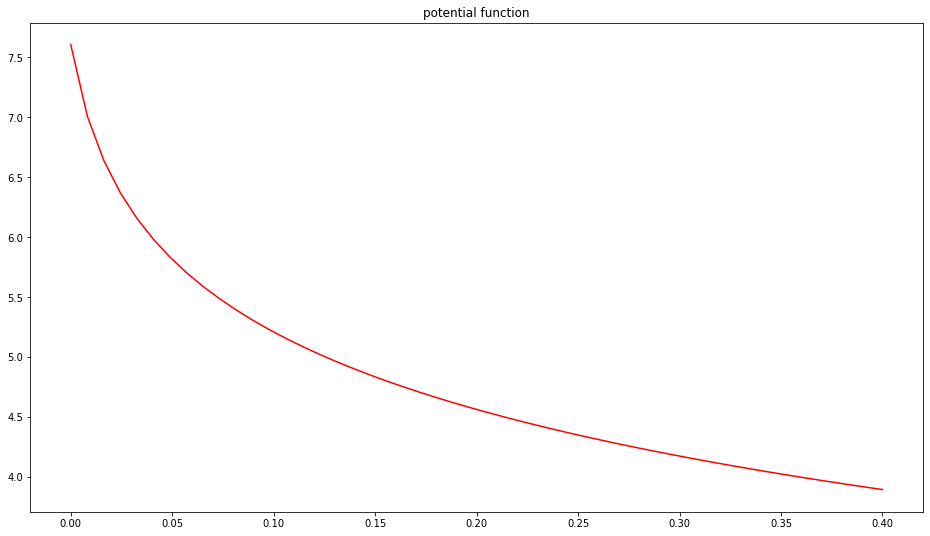

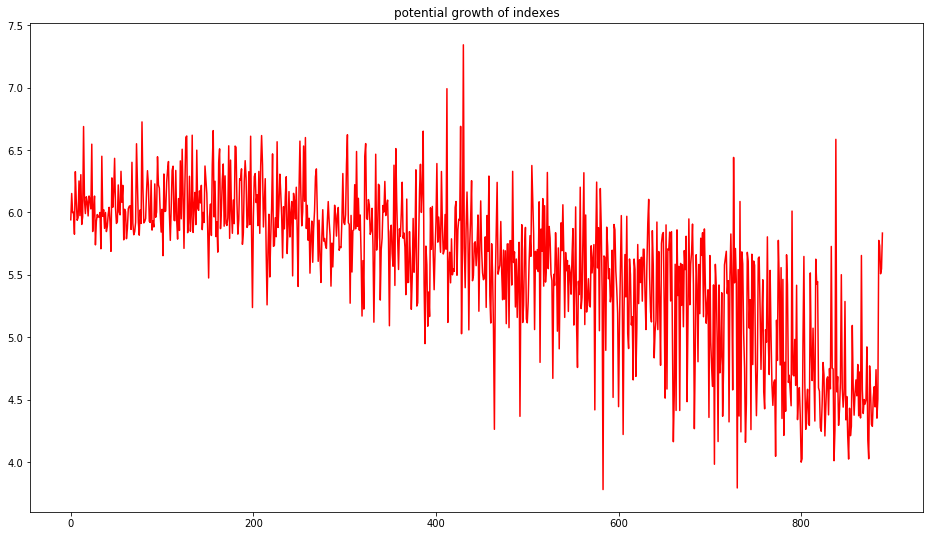

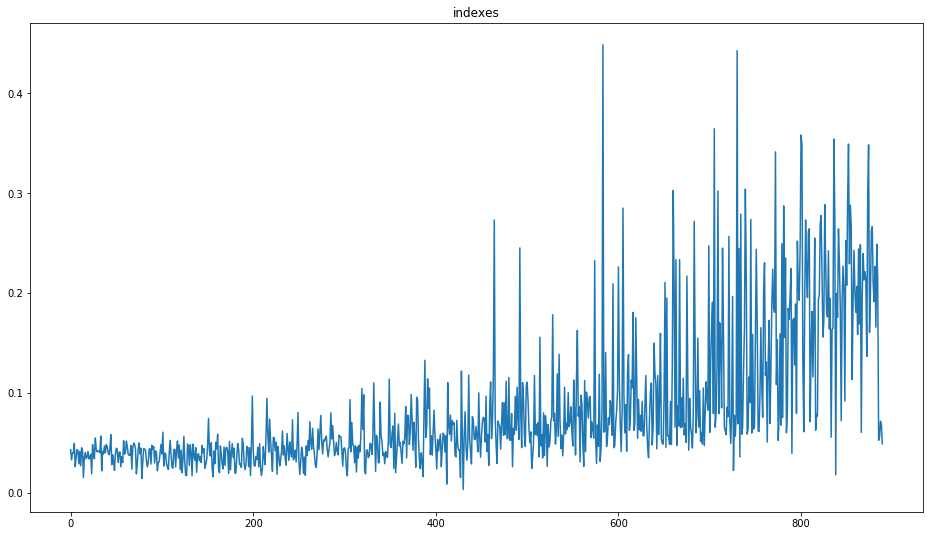

In [69]:
x = range(N)
x1 = np.linspace(0,0.4,50)
x2 = - np.log(x1 + 0.01) + 3
plt.figure(figsize=(16,9))
plt.title('potential function')
plt.plot(x1, x2, color = 'red')
plt.figure(figsize=(16,9))
plt.title('potential growth of indexes')
plt.plot(x, pot_index, color = 'red')
plt.figure(figsize=(16,9))
plt.title('indexes')
plt.plot(x, test_res)

The lower the index, the higher the potential.
Since we can try to implement sorting algorithm with galaxy checking

Firstly, we should check, is there a first 66 rows from 50 different galaxies. 

In [70]:
d_galaxies = dict()
for name in galaxies:
    d_galaxies.update({name: float(0)})

In [72]:
# d_galaxies

In [73]:
for row in range(66):
    d_galaxies[test['galaxy'][row]] += 1

In [74]:
for key, value in d_galaxies.items():
    if value >= 1:
        print(key,  value)

Virgo I 2.0
UGC 8651 (DDO 181) 2.0
KKh 060 2.0
KK98 77 6.0
Crater II 2.0
Andromeda XVII 4.0
Cetus III 1.0
Pegasus III 1.0
Wolf-Lundmark-Melotte (WLM, DDO 221) 5.0
Draco Dwarf (DDO 208) 4.0
Cassiopeia II (Andromeda XXX) 1.0
NGC 300 1.0
Antlia B 5.0
KKR 25 5.0
Leo V Dwarf 1.0
Segue 1 4.0
IC 3104 1.0
KKH 12 2.0
Andromeda XXIX 1.0
Andromeda VIII 1.0
Hydra II 8.0
Reticulum III 7.0


22 galaxies wtf

In [75]:
# extra

In [76]:
extra = cp.Variable(N)
# gala = cp.Variable(len(galaxies))

cost = extra*np.power(pot_index,2) /1000
constr = []
for i in range(N):
    constr += [extra[i] >= 0]
    constr += [extra[i] <= 100] # since the every row can't exceed galaxy's consumption limit
    
# for line in lines_gal_row:
#     constr += [cp.sum(line*extra) <= 100]
    
constr += [cp.sum(extra) <= 50000]
constr += [cp.sum(extra*row_low) >= 5000]

In [77]:
problem = cp.Problem(cp.Maximize(cost), constr)
problem.solve(solver=cp.SCS)

1807.0903023303615

In [78]:
extra.value

array([1.00003689e+02, 1.00003801e+02, 1.00003719e+02, 1.00003721e+02,
       1.00003628e+02, 1.00003898e+02, 1.00003769e+02, 1.00003686e+02,
       1.00003697e+02, 1.00003856e+02, 1.00003706e+02, 1.00003884e+02,
       1.00003669e+02, 1.00003701e+02, 1.00004106e+02, 1.00003770e+02,
       1.00003715e+02, 1.00003787e+02, 1.00003766e+02, 1.00003705e+02,
       1.00003790e+02, 1.00003775e+02, 1.00003734e+02, 1.00004023e+02,
       1.00003639e+02, 1.00003726e+02, 1.00003790e+02, 1.00003585e+02,
       1.00003681e+02, 1.00003711e+02, 1.00003700e+02, 1.00003701e+02,
       1.00003719e+02, 1.00003569e+02, 1.00003967e+02, 1.00003703e+02,
       1.00003731e+02, 1.00003652e+02, 1.00003719e+02, 1.00003639e+02,
       1.00003660e+02, 1.00003712e+02, 1.00003741e+02, 1.00003678e+02,
       1.00003558e+02, 1.00003870e+02, 1.00003742e+02, 1.00003807e+02,
       1.00003958e+02, 1.00003738e+02, 1.00003673e+02, 1.00003680e+02,
       1.00003839e+02, 1.00003721e+02, 1.00003709e+02, 1.00003899e+02,
      

In [79]:
sum(extra.value)

49997.05665240469

In [88]:
res_opt = extra.value

In [92]:
res_opt = np.round(res_opt,2)

### WTF
Convex solver is not okay. Let's try another

In [158]:
# import cvxopt as cv
# from cvxopt.modeling import variable

In [160]:
# x = variable(N,'extra')

variable(890,'extra')

In [ ]:
# cost = extra*np.power(pot_index,2) /1000

In [161]:
# c1 = (x <= 100)
# c2 = (x >= 0)

In [ ]:
# c3 = 

# Submission

In [93]:
indexes = []
for i in range(N):
    indexes.append(i)

In [94]:
# indexes

In [95]:
submission = pd.DataFrame({'index': indexes, 'pred': test_res, 'opt_pred': res_opt },)
submission.head()

,index,pred,opt_pred
0,0,0.042804,100.0
1,1,0.032789,100.0
2,2,0.039884,100.0
3,3,0.039693,100.0
4,4,0.049277,100.0


In [96]:
submission.shape

(890, 3)

In [97]:
import time
import os

current_timestamp = int(time.time())
submission_path = 'submissions/{}.csv'.format(current_timestamp)

if not os.path.exists('submissions'):
    os.makedirs('submissions')

print(submission_path)
submission.to_csv(submission_path, index=False)

submissions/1590432657.csv
